In [95]:
# for data
from statsmodels.graphics.api import abline_plot
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical tests
import scipy
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.ensemble import GradientBoostingClassifier

# for model persistence
import pickle

# for files
import os.path

# for explainer
from lime import lime_tabular

# for date
import datetime

# for HTTP
import requests

# for weather
import meteostat as met
from geopy.geocoders import Nominatim

# for dataframe nesting
from weatherData import WeatherData 

# show not only last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [96]:
geolocator = Nominatim(user_agent="hke-tgki/0.1")

def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

def prepareDtf(dtf):
    dtf.columns = dtf.columns.str.strip()
    cols = ["Bucket", "StartId", "StartName", "EndId", "EndName", "Count"]

    dtf = dtf[cols]
    dtf = dtf[dtf['Bucket'].str.len() == 10]
    dtf = dtf.groupby(["Bucket", "EndId", "EndName"])[
        "Count"].sum().reset_index()

    dtf["DoW"] = dtf["Bucket"].apply(
        lambda bucket: pd.to_datetime(bucket).day_name())

    dtf = dtf[dtf['Bucket'] >= '2020-04-01']

    dtf = dtf.rename(columns={"Count": "Y"})
  
    return dtf

def prepareDistricts(dtf):
    districts = dtf[['EndId', 'EndName']].copy()
    districts.drop_duplicates(subset = ["EndId"], inplace=True)
    # districts["Point"] = ""
    districts["Lat"] = ""
    districts["Lon"] = ""
    districts["Weather"] = ""
    for i in districts.index:
        lat, lon = getCoordsForDistrict(districts['EndName'][i])
        if (lat == None or lon == None): continue
        # districts.loc[i,'Point'] = point
        districts.loc[i,'Lat'] = lat
        districts.loc[i,'Lon'] = lon
    
    return districts

def removeOutliers(dtf, factor): 
    maxVisitors = dtf.sort_values(by=['Y'])
    q1 = np.quantile(maxVisitors['Y'], 0.50)
    q3 = np.quantile(maxVisitors['Y'], 0.90)
    iqr = q3 - q1

    minValue = q1 - factor*iqr
    maxValue = q3 + factor*iqr

    print("minValue: ", minValue, "\nmaxValue: ", maxValue)

    dtf = dtf[dtf['Y'] >= minValue]
    dtf = dtf[dtf['Y'] <= maxValue]
    return dtf
    
def printHeatmap(dtf):
    dic_cols = {col: utils_recognize_type(
        dtf, col, max_cat=20) for col in dtf.columns}
    heatmap = dtf.isnull()
    for k, v in dic_cols.items():
        if v == "num":
            heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
        else:
            heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
    sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
    plt.show()
    print("\033[1;37;40m Categerocial ",
          "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

def showKfoldValidation(model, x_train, y_train):
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1
    for train, test in cv.split(x_train, y_train):
        prediction = model.fit(x_train[train],
                               y_train[train]).predict(x_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3,
                    label='Fold %d (R2 = %0.2f)' % (i, score))
        i = i+1
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)],
             linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()

def scaleData(dtf, y):
    # scale X
    scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    X = scalerX.fit_transform(dtf.drop("Y", axis=1))
    dtf_scaled = pd.DataFrame(X, columns=dtf.drop(
        y, axis=1).columns, index=dtf.index)

    # scale Y
    scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    dtf_scaled[y] = scalerY.fit_transform(
        dtf[y].values.reshape(-1, 1))

    return dtf_scaled, scalerX, scalerY

def unscaleData(scalerY, predicted, y_test):
    predicted = scalerY.inverse_transform(
        predicted.reshape(-1, 1)).reshape(-1)
    y_test = scalerY.inverse_transform(
        y_test.reshape(-1, 1)).reshape(-1)
    return predicted, y_test

def printKPI(predicted, y_test):
    # print("R2 (explained variance):", round(
    #     metrics.r2_score(y_test, predicted), 3) * 100, "%")
    # print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
    #       round(np.mean(np.abs((y_test-predicted)/predicted)), 3) * 100, "%")
    print("Mean Absolute Error (Σ|y-pred|/n):",
          "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
          "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(Y_test, predicted))))
    print("95-percentile Mean Absolute Error:", 
          "{:,.0f}".format(round(np.mean(stats.trim1(np.abs((y_test-predicted)),0.05, "right")), 0)))

def computeResiduals(predicted, y_test):
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(
        min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(
        min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    return residuals, max_error, max_idx, max_true, max_pred

def printMaxErrorY(predicted, y_test):
    max_difference_y = 0
    max_dif = 0
    for idx, val in enumerate(y_test):
        dif = abs(val - predicted[idx])
        if(dif > max_dif):
            max_dif = dif
            max_difference_y = val
    print("Max Error Dataset:")
    print(dtf.loc[dtf['Y'] == max_difference_y, ["Bucket", "EndId", "Y"]])

def plotPredictionKPI(predicted, y_test, max_error, max_true, max_pred):
    # Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].scatter(predicted, Y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error,
                 color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    # Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black',
                 linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals",
              title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()
    plt.show()

def plotResidualDistribution(residuals):
    fig, ax = plt.subplots()
    sns.distplot(residuals, color="red", hist=True,
                 kde=True, kde_kws={"shade": True}, ax=ax)
    ax.grid(True)
    ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
    plt.show()

def getFreeDays(year):
    # Request free days from Feiertage API for year 2021 in bavaria
    free_days = requests.get(
        f'https://feiertage-api.de/api/?jahr={year}&nur_land=BY')

    # Parse result and store as [key, val] dict
    free_days = free_days.json()

    free_day_dates = []

    # Iterate over
    for free_day_name in free_days:
        free_day_dates.append(free_days[free_day_name]['datum'])

    return free_day_dates

def getHolidays(year):
    # Request free days from Feiertage API for year 2021 in bavaria
    holidays = requests.get(
    f'https://ferien-api.de/api/v1/holidays/BY/{year}')

    # Parse result and store as [key, val] dict
    holidays = holidays.json()

    holiday_dates = []

    # Iterate over
    for holiday in holidays:
        holiday_dates.append((holiday['start'], holiday['end']))

    return holiday_dates

def isWorkDay(datestring):
    freeDays =  ["Saturday", "Sunday"]
    return not (datetime.datetime.strptime(datestring, "%Y-%m-%d").strftime("%A") in freeDays)

def getCoordsForDistrict(districtName):
    location = geolocator.geocode(districtName)
    if (location == None):
        print(districtName)
        return None, None
    return location.latitude, location.longitude

def getTravellingDates(year, timespan=4): 
    holiday_dates = getHolidays(year)

    travelling_datestrings = []

    for date in holiday_dates:
        start = datetime.datetime.strptime(date[0], "%Y-%m-%dT%H:%MZ")
        end = datetime.datetime.strptime(date[1], "%Y-%m-%dT%H:%MZ")
        for i in range(0, timespan-1, 1):
            travelling_datestrings.append(datetime.datetime.strftime(start + datetime.timedelta(days=i), "%Y-%m-%d"))
            travelling_datestrings.append(datetime.datetime.strftime(end - datetime.timedelta(days=i),"%Y-%m-%d" ))

    return travelling_datestrings

def isTravellingDate(date):
    travellingDates = getTravellingDates(datetime.datetime.strptime(date, "%Y-%m-%d").year)
    return date in travellingDates

def getWeatherData(dtf, districts):
    # Set time period
    start = datetime.datetime.strptime(dtf.iloc[1]['Bucket'], "%Y-%m-%d")
    end = datetime.datetime.strptime(dtf.iloc[-1]['Bucket'], "%Y-%m-%d")

    for i in districts.index:
        districts.loc[i,'Weather'] = WeatherData(met.Daily(met.Point(districts['Lat'][i], districts['Lon'][i]), start, end).fetch())

def get_weather_for_date_and_point(date, point, desired_data = ['tmax', 'prcp']):
    weather_data = met.Daily(point, date, date).fetch()
    weather_dict = {}
    if(weather_data.empty): return None
    for data_col in desired_data:
        weather_dict[data_col] = weather_data.iloc[0][data_col]

    return weather_dict

def addWeatherData(dtf, districts): 
    dtf["MaxTemp"] = ""
    dtf["Precip"] = ""

    for i in dtf.index:
        id = dtf.loc[i, 'EndId']
        time = dtf.loc[i, 'Bucket']
        weatherData = districts.loc[(districts.EndId == id),'Weather'].values[0]

        if(weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time))].size < 1):
            continue

        dtf.loc[i, 'MaxTemp'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'tmax'].values[0]
        dtf.loc[i, 'Precip'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'prcp'].values[0]

def getPredictionDataStructure(numberOfRows):
    # Load csv with data structure
    dataFileName ="../data/mobilityDataAllgau_extended_dummies.csv"
    if os.path.isfile(dataFileName):
        dtf = pd.read_csv(dataFileName)
    else:
        print("Data file could not be loaded")
        return

    # Extract column names from data structure
    doWColumns = [col for col in dtf if col.startswith('DoW_')]
    dayColumns = [col for col in dtf if col.startswith('Day_')]
    weatherColumns = ["MaxTemp", "Precip"]
    endIdColumns = [col for col in dtf if col.startswith('EndId_')]
    columns = doWColumns + dayColumns + endIdColumns + weatherColumns

    # Create dtf with n rows
    data = np.array([np.zeros(numberOfRows, dtype=np.int32)]*columns.__len__()).T

    dtf = pd.DataFrame(data, columns=columns)
    dtf.fillna(0)

    return dtf

def getReturnDataStructure(numberOfRows):
    cols = ["Date", "DistrictId", "DistrictName", "MaxTemp", "Precip", "Visitors"]
    # Create dtf with single row
    data = np.array([np.zeros(numberOfRows, dtype=np.int32)]*cols.__len__()).T
    return pd.DataFrame(data, columns=cols)

def getDatesToPredict(startDate, endDate):
    now = datetime.datetime.today()
    startDate = datetime.datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d")

    intoFuture = endDate - now
    if(intoFuture.days > 10):
        print("Preditions more than 10 days into the future are too unreliable")
        return

    delta = endDate - startDate

    datestrings = []

    for i in range(delta.days + 1):
        day = startDate + datetime.timedelta(days=i)
        datestrings.append(day.strftime("%Y-%m-%d"))

    return datestrings

def getSavedDistricts():
     # Load districts
    districtsFileName = "../data/districts.csv"
    if os.path.isfile(districtsFileName):
        # load saved model
        return pd.read_csv("../data/districts.csv")
    else:
        print("No saved districts could be loaded")
        return None

def addPredictionDataset(dtf, predictions, districts, districtId, date, datasetIndex=0):
    predictions.loc[datasetIndex, 'Date'] = date
    predictions.loc[datasetIndex, 'DistrictId'] = districtId
    predictions.loc[datasetIndex, 'DistrictName'] = districts.loc[(districts.EndId == districtId), 'EndName'].values[0]

    # Fill in EndId and date values
    endIdColumn = 'EndId_' + str(districtId)
    dtf.loc[datasetIndex, endIdColumn] = 1
    
    # Generate datetime object from passed date
    dateObject = datetime.datetime.strptime(date, "%Y-%m-%d")

    # Fill in DoW type  
    dtf.loc[datasetIndex, "DoW_" + dateObject.strftime("%A")] = 1

    # Fill in Day_class_work
    dtf.loc[datasetIndex, "Day_class_work"] = int(isWorkDay(date))

    # Fill in Day_class_travel type
    dtf.loc[datasetIndex, "Day_class_travel"] = int(isTravellingDate(date))

    # print(dtf[["MaxTemp", "Precip"]].head())

    # Get and add weather data
    weatherData = get_weather_for_date_and_point(dateObject, met.Point(districts.loc[(districts.EndId == districtId), 'Lat'].values[0], districts.loc[(districts.EndId == districtId), 'Lon'].values[0]))
    if(weatherData == None): return dtf, predictions
    dtf.loc[datasetIndex, "MaxTemp"] = weatherData["tmax"]
    dtf.loc[datasetIndex, "Precip"] = weatherData["prcp"]
    predictions.loc[datasetIndex, 'MaxTemp'] = weatherData["tmax"]
    predictions.loc[datasetIndex, "Precip"] = weatherData["prcp"]

    return dtf, predictions

def predict(dtf):
    modelFileName = "mobilityPredictionModel.sav"
    if os.path.isfile(modelFileName):
        # load saved model
        model = pickle.load(open(modelFileName, 'rb'))
    else:
        print("No saved model could be loaded")
        return

    return np.int32(np.round(model.predict(dtf.values), decimals=0))
    
def singlePredict(districtId, date):
    dtf = getPredictionDataStructure(1)
    predictions = getReturnDataStructure(1)
    districts = getSavedDistricts()
    if(districts.empty): return
    dtf, predictions = addPredictionDataset(dtf, predictions, districts, districtId, date)
    predictions['Visitors'] = predict(dtf)
    return predictions

def multiPredict(districtIds, startdate, enddate):
    districts = getSavedDistricts()
    if(districts.empty): return
    dates = getDatesToPredict(startdate, enddate)
    predictions = getReturnDataStructure(len(districtIds)*len(dates))
    dtf = getPredictionDataStructure(len(districtIds)*len(dates))
    for i, districtId in enumerate(districtIds):
        for j, date in enumerate(dates):
            dtf, predictions = addPredictionDataset(dtf, predictions, districts, districtId, date, i*len(dates)+j)
    predictions['Visitors'] = predict(dtf)
    return predictions


In [97]:
dtf = pd.read_csv("../data/mobilityDataAllgau.csv")
dtf = prepareDtf(dtf)

In [98]:
districts = prepareDistricts(dtf)
districts.to_csv("../data/districts.csv")

Rostock - Ortsbeirat 18 : Gehlsdrf,Hinrichsdorf,Jürgenshof,Krummendorf,Nienhagen,Peez,Stuthof


In [99]:
# Load saved districts
districts = pd.read_csv("../data/districts.csv")
districts.head()

,Unnamed: 0,EndId,EndName,Lat,Lon,Weather
0,34472,2701700,Rendsburg-Eckernförde,54.327870,9.720589,NaN
1,34473,6233900,Saale-Orla-Kreis,50.586455,11.776174,NaN
2,34474,6234000,Baden-Baden,48.758078,8.241524,NaN
3,34475,6234300,Rheinisch-Bergischer Kreis,51.014037,7.171613,NaN
4,34476,6234400,Rottweil - Landkreis Rottweil,48.165531,8.625128,NaN


In [100]:
getWeatherData(dtf, districts)
addWeatherData(dtf, districts)
dtf.to_csv("../data/mobilityDataAllgau_extended_weather.csv")

In [101]:
# Load data with weather
dtf = pd.read_csv("../data/mobilityDataAllgau_extended_weather.csv")
dtf.head()

,Unnamed: 0,Bucket,EndId,EndName,Y,DoW,MaxTemp,Precip
0,34472,2020-04-01,2701700,Rendsburg-Eckernförde,7,Wednesday,8.4,0.2
1,34473,2020-04-01,6233900,Saale-Orla-Kreis,32,Wednesday,7.5,0.0
2,34474,2020-04-01,6234000,Baden-Baden,7,Wednesday,11.6,0.0
3,34475,2020-04-01,6234300,Rheinisch-Bergischer Kreis,7,Wednesday,11.7,0.0
4,34476,2020-04-01,6234400,Rottweil - Landkreis Rottweil,67,Wednesday,10.1,0.0


In [102]:
# Remove invalid values
print("Rows before NaN removal: ", dtf.shape[0])
dtf.replace([np.inf, -np.inf], np.NaN, inplace=True)
dtf.replace("", np.NaN, inplace=True)
dtf.dropna(how='any', axis=0, inplace=True)
print("Rows after NaN removal: ",dtf.shape[0])

Rows before NaN removal:  95418
Rows after NaN removal:  94654


In [103]:
# define clusters (workingday/weekend)
x = "Day"
Day_clusters = {"free": ["Saturday", "Sunday"], "work": ["Monday", "Tuesday", "Wednesday",
                                                         "Thursday", "Friday"]}
# create DoW_class columns
dic_flat = {v: k for k, lst in Day_clusters.items() for v in lst}
for k, v in Day_clusters.items():
    if len(v) == 0:
        residual_class = k
dtf[x+"_class"] = dtf['DoW'].apply(lambda x: dic_flat[x] if x in
                                   dic_flat.keys() else residual_class)

# create dummies Day_class
dummy = pd.get_dummies(dtf["Day_class"],
                       prefix="Day_class", drop_first=True)
dtf = pd.concat([dtf, dummy], axis=1)
freeDays = getFreeDays('2020')
for day in freeDays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_work'] = 0

travellingDays = getTravellingDates('2020')
dtf['Day_class_travel'] = 0
for day in travellingDays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_travel'] = 1
    
# drop the original column
dtf = dtf.drop("Day_class", axis=1)

dtf.head()


# create dummies DoW
dummy = pd.get_dummies(dtf["DoW"],
                       prefix="DoW", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)
# drop the original column
dtf = dtf.drop("DoW", axis=1)


# create dummies EndId
dummy = pd.get_dummies(dtf["EndId"],
                       prefix="EndId", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)


,Unnamed: 0,Bucket,EndId,EndName,Y,DoW,MaxTemp,Precip,Day_class_work,Day_class_travel
0,34472,2020-04-01,2701700,Rendsburg-Eckernförde,7,Wednesday,8.4,0.2,1,0
1,34473,2020-04-01,6233900,Saale-Orla-Kreis,32,Wednesday,7.5,0.0,1,0
2,34474,2020-04-01,6234000,Baden-Baden,7,Wednesday,11.6,0.0,1,0
3,34475,2020-04-01,6234300,Rheinisch-Bergischer Kreis,7,Wednesday,11.7,0.0,1,0
4,34476,2020-04-01,6234400,Rottweil - Landkreis Rottweil,67,Wednesday,10.1,0.0,1,0


In [104]:
# Save extended data
dtf.to_csv("../data/mobilityDataAllgau_extended_dummies.csv")

In [105]:
# Load extended data
dtf = pd.read_csv("../data/mobilityDataAllgau_extended_dummies.csv")
dtf.head()

,Unnamed: 0,Unnamed: 0.1,Bucket,EndId,EndName,Y,MaxTemp,Precip,Day_class_work,Day_class_travel,...,EndId_280639000,EndId_280662300,EndId_280877400,EndId_281285000,EndId_281285100,EndId_281285200,EndId_667985900,EndId_667985901,EndId_667985902,EndId_667985903
0,0,34472,2020-04-01,2701700,Rendsburg-Eckernförde,7,8.4,0.2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,34473,2020-04-01,6233900,Saale-Orla-Kreis,32,7.5,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,34474,2020-04-01,6234000,Baden-Baden,7,11.6,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,34475,2020-04-01,6234300,Rheinisch-Bergischer Kreis,7,11.7,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,34476,2020-04-01,6234400,Rottweil - Landkreis Rottweil,67,10.1,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# define training and test features
DoWColumns = [col for col in dtf if col.startswith('DoW_')]
DayColumns = [col for col in dtf if col.startswith('Day_')]
WeatherColumns = ["MaxTemp", "Precip"]
EndIdColumns = [col for col in dtf if col.startswith('EndId_')]
X_names = DoWColumns + DayColumns + EndIdColumns + WeatherColumns

relevantDtf = dtf[X_names + ["Y"]]

# split data
dtfTrain, dtfTest = model_selection.train_test_split(relevantDtf,
                                                     test_size=0.2)

X_train = dtfTrain[X_names].values
Y_train = dtfTrain["Y"].values
X_test = dtfTest[X_names].values
Y_test = dtfTest["Y"].values

In [107]:
filename = "mobilityPredictionModel.sav"

if os.path.isfile(filename):
    # load saved model
    model = pickle.load(open(filename, 'rb'))
else:
    # create model
    # model = linear_model.LinearRegression()
    model = ensemble.GradientBoostingRegressor()

    # train
    model.fit(X_train, Y_train)

    # save model
    pickle.dump(model, open("mobilityPredictionModel.sav", 'wb'))

# showKfoldValidation(model, X_train, Y_train)  

In [108]:
# test
predicted = model.predict(X_test)

Mean Absolute Error (Σ|y-pred|/n): 1,327
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 8,070
95-percentile Mean Absolute Error: 394
Max Error: 229,283
Max Error Dataset:
           Bucket    EndId       Y
71356  2020-10-14  6241500  710596


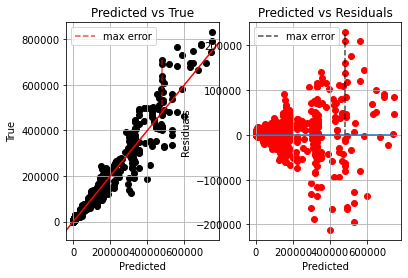

In [109]:
printKPI(predicted, Y_test)

# residuals
residuals, max_error, max_idx, max_true, max_pred = computeResiduals(
    predicted, Y_test)

printMaxErrorY(predicted, Y_test)

plotPredictionKPI(predicted, Y_test, max_error, max_true, max_pred)

In [110]:
singlePredict(6241500, "2021-05-15").head()     
singlePredict(6241500, "2021-07-22").head()       
singlePredict(6241500, "2021-08-20").head()       
singlePredict(6241500, "2021-09-02").head()

,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-05-15,6241500,Oberallgäu - Landkreis Oberallgäu,11,13.1,418367


,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-07-22,6241500,Oberallgäu - Landkreis Oberallgäu,22.4,0,662256


,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-08-20,6241500,Oberallgäu - Landkreis Oberallgäu,19.7,0,599556


,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-09-02,6241500,Oberallgäu - Landkreis Oberallgäu,19.2,0,560249


In [111]:
# Oberallgäu    6241500
# Kempten       6270100
# Memmingen     6259000

multiPredict([6241500, 6270100, 6259000], "2021-12-23", "2021-12-26").head(21)

,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-12-23,6241500,Oberallgäu - Landkreis Oberallgäu,3.5,0.0,451783
1,2021-12-24,6241500,Oberallgäu - Landkreis Oberallgäu,0.0,0.0,427935
2,2021-12-25,6241500,Oberallgäu - Landkreis Oberallgäu,0.0,0.0,364989
3,2021-12-26,6241500,Oberallgäu - Landkreis Oberallgäu,0.0,0.0,327308
4,2021-12-23,6270100,Kempten (Allgäu),5.0,0.0,177157
5,2021-12-24,6270100,Kempten (Allgäu),8.1,0.4,169667
6,2021-12-25,6270100,Kempten (Allgäu),7.3,1.2,146570
7,2021-12-26,6270100,Kempten (Allgäu),6.7,0.0,110433
8,2021-12-23,6259000,Memmingen,3.8,0.0,128000
9,2021-12-24,6259000,Memmingen,6.6,1.3,129430
